<a href="https://colab.research.google.com/github/SiluniKeerthiratne/DSGP/blob/nisal/%20v3%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook

In [17]:
# Assuming the 'fruit-dta' directory is in the root of your Google Drive
root_dir = '/content/drive/MyDrive/ColabNotebooks/fruit-dta'

In [18]:
# List of fruit classes: 'apple', 'mango', 'banana'
fruit_classes = ['apple','banana','mango','tomato'] # add more fruits and veg classes
ripeness_classes = ['0 unripe', '1 partially ripe', '2 ripe']

X = []
y = []

for fruit_class in fruit_classes:
    for ripeness_class_label, ripeness_class in enumerate(ripeness_classes):
        class_path = os.path.join(root_dir, fruit_class, ripeness_class)
        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (244, 244))
            X.append(img)
            y.append(ripeness_class_label)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 237/237 [00:03<00:00, 76.47it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [19]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
import numpy as np

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [21]:
# Print shapes
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (477, 244, 244, 3)
X_test Shape:  (236, 244, 244, 3)
y_train Shape:  (477,)
y_test Shape:  (236,)


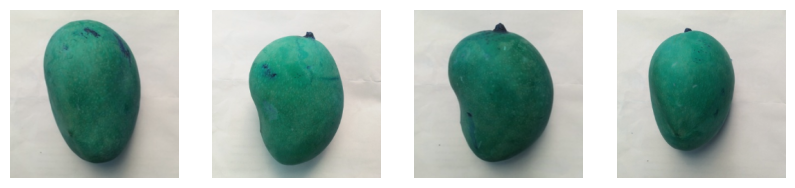

In [22]:
# Visualization (optional)
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [23]:
# Model Building (continuation)
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers

img_rows, img_cols = 244, 244

In [24]:
# Load InceptionV3 model with pre-trained weights
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

In [25]:
# Freeze the layers
for layer in inception.layers:
    layer.trainable = False

In [26]:
# Custom head
def custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [28]:
# Add custom head on top of InceptionV3
num_classes = len(ripeness_classes)
FC_Head = custom_head(inception, num_classes)
model = Model(inputs=inception.input, outputs=FC_Head)


In [29]:
# Model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 121, 121, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 121, 121, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

In [30]:
# Model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Model Training
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1, initial_epoch=0)

Epoch 1/30
15/15 [==============================] - 115s 7s/step - loss: 27.5094 - accuracy: 0.4214 - val_loss: 2.4877 - val_accuracy: 0.7500
Epoch 2/30
15/15 [==============================] - 95s 7s/step - loss: 4.9713 - accuracy: 0.5744 - val_loss: 2.2073 - val_accuracy: 0.7161
Epoch 3/30
15/15 [==============================] - 104s 7s/step - loss: 2.0838 - accuracy: 0.6457 - val_loss: 1.7498 - val_accuracy: 0.7161
Epoch 4/30
15/15 [==============================] - 105s 7s/step - loss: 1.7668 - accuracy: 0.7254 - val_loss: 1.5833 - val_accuracy: 0.7797
Epoch 5/30
15/15 [==============================] - 95s 7s/step - loss: 1.7144 - accuracy: 0.6709 - val_loss: 1.5275 - val_accuracy: 0.8008
Epoch 6/30
15/15 [==============================] - 93s 6s/step - loss: 1.6346 - accuracy: 0.6813 - val_loss: 1.4328 - val_accuracy: 0.8008
Epoch 7/30
15/15 [==============================] - 105s 7s/step - loss: 1.5832 - accuracy: 0.6834 - val_loss: 1.4494 - val_accuracy: 0.7415
Epoch 8/30
15/1

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


8/8 [==============================] - 31s 4s/step - loss: 0.9944 - accuracy: 0.8644

Test Accuracy: 86.44%


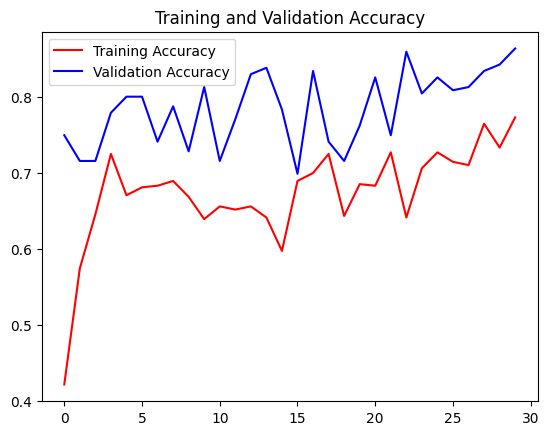

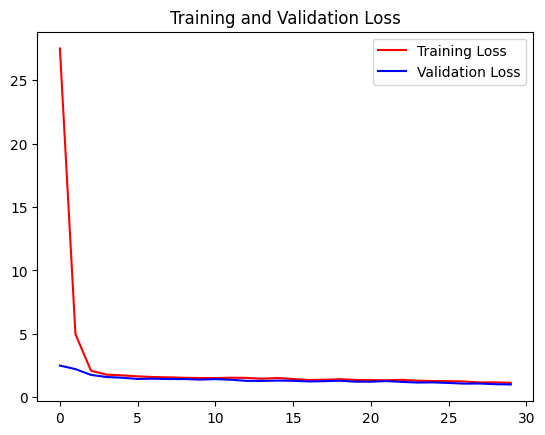

In [35]:
# Visualization of Training History
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [39]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/ColabNotebooks/fruit-dta/trained_model.h5')
